In [161]:
%matplotlib inline

import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.optimize import curve_fit

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 7,5

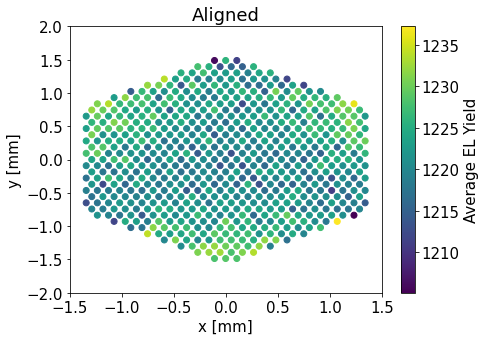

,q,r,excitation
423,-0.653061,0.285714,1222.521739
424,-0.653061,0.326531,1232.036364
425,-0.653061,0.367347,1231.000000
470,-0.612245,0.204082,1223.250000
471,-0.612245,0.244898,1226.075000
...,...,...,...
1929,0.612245,-0.244898,1223.241379
1930,0.612245,-0.204082,1219.888889
1975,0.653061,-0.367347,1205.100000
1976,0.653061,-0.326531,1219.625000


In [162]:
# Load in the unit cell and create map
unitcell = pd.read_hdf("../Maps/unitcell_Shifted.h5","Yields")
# unitcell = pd.read_hdf("../Maps/unitcell_Aligned.h5","Yields")



# Plot the loaded in unitcell
plt.figure()
sc = plt.scatter(unitcell["x"], unitcell["y"], c=unitcell["excitation"])
plt.colorbar(sc, label='Average EL Yield')
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title("Aligned")
plt.xlim(-1.5, 1.5)
plt.ylim(-2., 2.)
plt.tight_layout() 
plt.show()


unitcell = unitcell.drop(columns = ["x", "y"])
unitcell['q'] = unitcell['q'].astype(float)
unitcell['r'] = unitcell['r'].astype(float)
unitcell['excitation'] = unitcell['excitation'].astype(float)
display(unitcell)

In [163]:
# Load in the input file

mode = "kr"


if (mode == "kr"):
    input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus_40keV.next.h5"
else:
    input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus.next.h5"

## True hits (deposited energy)
hits = pd.read_hdf(input_file, 'MC/hits')
hits = hits[hits["label"] == "ACTIVE"]
hits = hits.drop(columns = ["label", "hit_id", "time", "particle_id"])

# Replace nan to zeros
hits['energy'] = hits['energy'].fillna(0)

In [164]:
# Calculate the total energy of each hit
hitsum = hits
hitsum = hitsum.drop(columns = ["x", "y", "z"])
hitsum['Esum'] = hitsum.groupby(["event_id"])["energy"].transform('sum')
hitsum = hitsum.drop(columns = ["energy"])
hitsum = hitsum.drop_duplicates()

if (mode == "bb"):
    # Get a list of events who do not deposit all their energy in the detector
    bad_events = hitsum[hitsum["Esum"] != 2.458].event_id.values

    # Filter the main hit list from the bad events
    hits = hits[~hits.event_id.isin(bad_events)]

    # Filter the event number
    # hits = hits[hits["event_id"] < 50]

# Change the units of energy to eV
hits["energy"] = hits["energy"]*1e6
hits["ni"] = hits["energy"]/22.0
hits["ni"] = hits["ni"].round()

# Calculate the transverse diffusion sigma
D_T = 1.07 # mm/cm^0.5
hits["sigma"] = np.sqrt(hits["z"] * 0.1) * D_T # [mm]
print(hits["sigma"].max())
print(hits["sigma"].min())

print("z:", hits["z"].max())
print("z:", hits["z"].min())

print("x:", hits["x"].max())
print("x:", hits["x"].min())

print("y:", hits["y"].max())
print("y:", hits["y"].min())

print(hits["ni"].sum())

# Get rid of hits that do not have any energy deposits
hits = hits[hits["ni"] != 0]

# Drop the energy and z columns
hits = hits.drop(columns = ["energy"])


# Get the average z position of the event
hits['z_mean'] = hits.groupby(["event_id"])["z"].transform('mean')
hits = hits.drop(columns = ["z"])
hits = hits[hits["z_mean"] > 100]

display(hits)
print(len(hits.event_id.unique()))


7.805080413818359
0.10700000822544098
z: 532.092529296875
z: 0.10000000149011612
x: 207.47586059570312
x: -207.35569763183594
y: 202.8834991455078
y: -207.8899383544922
17981302.0


,event_id,x,y,ni,sigma,z_mean
15,1,-21.412849,-109.079842,59.0,4.526708,178.965775
16,1,-21.380720,-109.018623,326.0,4.526927,178.965775
17,1,-21.402328,-109.063484,548.0,4.526761,178.965775
18,1,-21.420282,-109.046928,157.0,4.526765,178.965775
19,1,-21.431898,-109.033951,30.0,4.526698,178.965775
...,...,...,...,...,...,...
121396,9998,147.292694,-44.027046,36.0,4.510258,177.665894
121397,9998,147.284561,-44.028320,106.0,4.510294,177.665894
121398,9998,147.283035,-44.033710,106.0,4.510314,177.665894
121399,9998,147.282745,-44.031467,188.0,4.510345,177.665894


8018


In [165]:
# Transform x, y positions to unit cell positions
hexsize = (1.25+0.127/2.0)/(np.cos(30*np.pi/180))
print(hexsize)

# Define bins in q and r space
numbins = 50

bins_q, bw_q  = np.linspace(-1, +1, numbins, retstep=True)
bins_centre_q = np.linspace(-1+bw_q/2, 1+bw_q/2, numbins)[:-1]

bins_r, bw_r  = np.linspace(-1, +1, numbins, retstep=True)
bins_centre_r = np.linspace(-1+bw_r/2, 1+bw_r/2, numbins)[:-1]

# Calculate the nearest hexagon centre to the point
def hex_round(q,r,s,mode):
    qi = int(round(q))
    ri = int(round(r))
    si = int(round(s))
    q_diff = abs(qi - q)
    r_diff = abs(ri - r)
    s_diff = abs(si - s)
    
    if q_diff > r_diff and q_diff > s_diff:
        qi = -ri - si
    else:
        if r_diff > s_diff:
            ri = -qi - si
        else:
            si = -qi - ri
    
    if (mode == "q"):
        return qi
    elif (mode == "r"):
        return ri
    else:
        return si


def GetHexCoords(df):
    # Calculate q and r values for hits table
    df["q"] = (df["x"] * np.sqrt(3)/3.0 - 1.0/3.0*df["y"]) / hexsize 
    df["r"] = (2.0/3.0)*df["y"] / hexsize
    df["s"] = -df["q"] - df["r"]

    # Calculate the multiple of q and r of the hexagon ~ 50 s
    df["nq"] = df.apply(lambda df_: hex_round(df_["q"], df_["r"], df_["s"], "q"), axis = "columns", result_type='expand' )
    df["nr"] = df.apply(lambda df_: hex_round(df_["q"], df_["r"], df_["s"], "r"), axis = "columns", result_type='expand' )

    # Shift the values to unit cell
    df["q"] = df["q"] - df["nq"]
    df["r"] = df["r"] - df["nr"]

    # Drop columns that are now not needed
    df = df.drop(columns = ["s", "nq","nr", "x", "y"])

    # Now bin the data ~20s
    df['q'] = pd.cut(x=df['q'], bins=bins_q,labels=bins_centre_q, include_lowest=True)
    df['r'] = pd.cut(x=df['r'], bins=bins_r,labels=bins_centre_r, include_lowest=True)
    return df

1.5166991571611466


In [166]:
rng = np.random.default_rng()

evid = -1

Yieldsum = 0

Yields = []
z_avg = []

for ev,x,y,ni,sigma,z in zip(hits["event_id"], hits["x"], hits["y"], hits["ni"], hits["sigma"], hits["z_mean"]):

    temp_df = pd.DataFrame()

    if (evid != ev):

        if (Yieldsum != 0):
            print("Event:", ev, "Yield: ",Yieldsum)
            Yields.append(Yieldsum)
            z_avg.append(z)

        Yieldsum = 0
        evid = ev

        # if(ev % 10 == 0):
        print(ev)
    
    # Calculate smeared position for each electron
    mean = (x, y)
    cov = [[sigma, 0], [0, sigma]]
    x_samp, y_samp = rng.multivariate_normal(mean, cov, int(ni)).T

    # Create a dataframe and bin the x and y sample
    temp_df["x"] = x_samp
    temp_df["y"] = y_samp

    # Transform the sampled x,y position to a binned q,r position in the hexagon unit cell
    temp_df = GetHexCoords(temp_df)
    
    Yieldsum += pd.merge(temp_df, unitcell, how ='inner', on =['q', 'r']).excitation.sum()
    # print(Yieldsum)


1
Event: 2 Yield:  2223085.0999203366
2
Event: 3 Yield:  2223408.4909418793
3
Event: 4 Yield:  2220912.6451290706
4
Event: 5 Yield:  2221891.6660770355
5
Event: 6 Yield:  2221965.7945129997
6
Event: 7 Yield:  2220781.2043264136
7
Event: 8 Yield:  2220952.5548604713
8
Event: 9 Yield:  2221816.578458452
9
Event: 10 Yield:  2221095.4362790305
10
Event: 11 Yield:  2222076.484133957
11
Event: 12 Yield:  2220541.6569108036
12
Event: 13 Yield:  2221802.2648406546
13
Event: 15 Yield:  2221937.285155895
15
Event: 16 Yield:  2222932.2315756995
16
Event: 17 Yield:  2222064.919536823
17
Event: 18 Yield:  2223614.238245311
18
Event: 19 Yield:  2223447.0040504043
19
Event: 20 Yield:  2224524.7771399175
20
Event: 22 Yield:  2223146.296455458
22
Event: 23 Yield:  2222966.6084551383
23
Event: 24 Yield:  2219660.623448343
24
Event: 25 Yield:  2221842.817464445
25
Event: 26 Yield:  2219638.8018706515
26
Event: 27 Yield:  2223331.382605803
27
Event: 28 Yield:  2220777.883218965
28
Event: 29 Yield:  222200

,Yield,z
0,2.223085e+06,327.783752
1,2.223408e+06,132.266464
2,2.220913e+06,343.813782
3,2.221892e+06,406.501434
4,2.221966e+06,144.081833
...,...,...
8012,2.222052e+06,509.401306
8013,2.223125e+06,133.308777
8014,2.222034e+06,344.699890
8015,2.222065e+06,378.961945


2222062.7849278254
2179.0
[1.97900000e+03 2.22217186e+00 1.04357466e-03]
Resolution =  0.11036052119638189


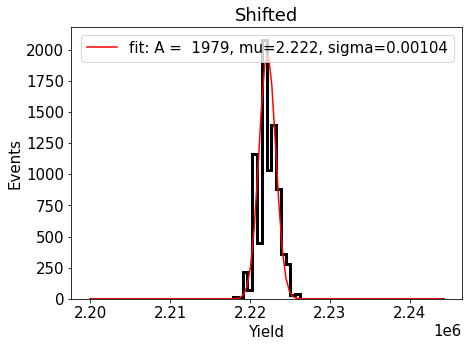

In [167]:
# Make a histogram of the total photon yeilds
plt.figure()

Yields_df = pd.DataFrame()
Yields_df["Yield"] = Yields
Yields_df["z"] = z_avg 
display(Yields_df)


# Optionally load in file with higher stats
# Yields_df = pd.read_hdf("../Files/Shifted/Yields_Merge_Shifted.h5")
# # Yields_df = pd.read_hdf("../Files/Aligned/Yields_Merge_Aligned.h5")
Yields = Yields_df.Yield.values


if (mode == "kr"):
    # bins_x = np.linspace(2.21e6, 2.23e6, 15)
    bins_x = np.linspace(2.05e6, 2.07e6, 50)
    scale = 1e6
else:
    bins_x = np.linspace(1.365e8, 1.366e8, 15)
    scale = 1e8

bins_x = np.linspace(np.median(Yields)-np.median(Yields)*0.01, np.median(Yields)+np.median(Yields)*0.01, 75)
print(np.median(Yields))

counts, xbins, _ = plt.hist(Yields, bins = bins_x, histtype="step", color = "black", linewidth=3)
# plt.xlim(-200, 6200)
plt.xlabel("Yield")
plt.ylabel("Events")

xbins/=scale

# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

bin_centers = xbins+ (xbins[1]-xbins[0])/2.0
bin_centers = bin_centers[:-1]

print(max(counts)+100)

popt, pcov = curve_fit(Gaussian_, bin_centers, counts, bounds  = ([max(counts)-100 , np.median(bin_centers)-np.median(bin_centers)*0.0001, 0], [max(counts)+100, np.mean(bin_centers)+np.mean(bin_centers)*0.0001, np.inf]), maxfev=50000)
print(popt)

plt.plot(np.linspace(min(bin_centers)*scale, max(bin_centers)*scale, 100), Gaussian_(np.linspace(min(bin_centers), max(bin_centers), 100), *popt), 'r-',label='fit: A = %5.0f, mu=%5.3f, sigma=%5.5f' % tuple(popt))
print("Resolution = ",100* 2.35*popt[2]/popt[1] )

plt.title("Shifted")
plt.legend()
plt.show()
